In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import nltk
from pprint import pprint
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
import numpy as np
from IPython.display import display, HTML

# Setting width of the notebook to 85% of screen width
display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 80%; }
</style>
"""))

%matplotlib inline
nltk.download('wordnet')
lmtzr = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/harsha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def load(path, kind):
    pickle_path = '{}/master.pkl'.format(path)
    if os.path.exists(pickle_path):
        return pd.read_pickle(pickle_path, compression='gzip')
    
    df = pd.DataFrame(columns=['_document','_data','_class'])
    
    for root, dirname, files in os.walk('{}/{}/neg'.format(path,kind)):
        files = [os.path.join(root,fname) for fname in files]
        for file in files:
            with open(file, 'rt') as f:
                df = df.append({'_document':file,'_data':f.read(), '_class':'neg'}, ignore_index=True)

        for root, dirname, files in os.walk('{}/{}/pos'.format(path,kind)):
            files = [os.path.join(root,fname) for fname in files]
            for file in files:
                with open(file, 'rt') as f:
                    df = df.append({'_document': file,'_data':f.read(), '_class':'pos'}, ignore_index=True)
    df = df.sample(frac=1.0)
    df.to_pickle(pickle_path, compression='gzip')
    return df

In [3]:
df = load('data/aclImdb','train')

In [4]:
def split(df, sl):
    sl = int(df.shape[0]*sl)
    return (df[:sl].copy(), df[sl:].copy())

In [5]:
train_df, dev_df = split(df, 0.7)

In [6]:
print(train_df.shape)
train_df.head()

(17500, 3)


,_document,_data,_class
9652,data/aclImdb/train/neg/12371_1.txt,This movie could have been great(cause its got...,neg
11821,data/aclImdb/train/neg/4380_1.txt,Plot: an amorous couple decide to engage in so...,neg
10614,data/aclImdb/train/neg/6264_2.txt,Nightmare Weekend is proof positive that some ...,neg
8726,data/aclImdb/train/neg/6638_4.txt,A note to all of you budding film writers: Stu...,neg
14433,data/aclImdb/train/pos/75_8.txt,The great Vincent Price has done many fantasti...,pos


In [7]:
print(dev_df.shape)
dev_df.head()

(7500, 3)


,_document,_data,_class
6658,data/aclImdb/train/neg/2614_1.txt,A sequel to (actually a remake of) Disney's 19...,neg
13042,data/aclImdb/train/pos/10870_8.txt,"Personally, I find the movie to be quite a goo...",pos
24497,data/aclImdb/train/pos/5983_8.txt,I first saw this film as a teenager. It was at...,pos
14548,data/aclImdb/train/pos/5012_10.txt,"In April of 1965, CBS broadcast the first of B...",pos
3009,data/aclImdb/train/neg/8146_2.txt,1st watched 11/7/2002 - 2 out of 10(Dir-John B...,neg


In [8]:
def remove_punctuation(document):
    document = re.sub('[-:;\'\"()?!]', ' ', document.lower())
    document = re.sub('</*\s*\w+\s*/*>', ' ', document)
    document = re.sub('[,/]',' ',document)
    document = re.sub('\.+',' ',document)
    document = re.sub('\d+','',document)
    document = re.sub('\s+',' ', document)
    return document.split(' ')

In [9]:
stopwords = ["a","i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
             "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", 
             "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
             "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
             "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
             "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for",
             "with", "about", "against", "between", "into", "through", "during", "before", "after", "above",
             "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
             "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", 
             "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only",
             "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

def remove_stopwords(document):
    return list(filter(lambda word: word not in stopwords, document))
    

In [10]:
def remove_rare_words(document):
    unq = set(document)
    return list(filter(lambda word: document.count(word)>=2, unq))

In [11]:
def lemmatize(document):
    return [lmtzr.lemmatize(word) for word in document]

In [12]:
def clean(document):
    document = remove_punctuation(document)
    document = remove_stopwords(document)
    document = remove_rare_words(document)
    document = lemmatize(document)
    return document

In [13]:
train_df['_data'] = train_df['_data'].apply(lambda doc: clean(doc))
train_df.head(10)

,_document,_data,_class
9652,data/aclImdb/train/neg/12371_1.txt,"[severely, watch, never, piece, people, movie,...",neg
11821,data/aclImdb/train/neg/4380_1.txt,"[movie, car, couple]",neg
10614,data/aclImdb/train/neg/6264_2.txt,"[weekend, effect, even, beautiful, almost, sci...",neg
8726,data/aclImdb/train/neg/6638_4.txt,"[story, aiken, holiday, first, break, street, ...",neg
14433,data/aclImdb/train/pos/75_8.txt,"[however, greatest, horror, vincent, revenge, ...",pos
7062,data/aclImdb/train/neg/942_2.txt,"[movie, night, naked, know, time, next, really...",neg
17845,data/aclImdb/train/pos/5085_7.txt,"[immediately, cliché, plot, fiona, piece, dr, ...",pos
4229,data/aclImdb/train/neg/1059_2.txt,"[would, bunch, movie, criminal, tedious, strug...",neg
16031,data/aclImdb/train/pos/5407_7.txt,"[movie, three, even, third, kid, nothing, re, ...",pos
8580,data/aclImdb/train/neg/104_3.txt,"[although, story, chronicle, short, strange, f...",neg


In [14]:
dev_df['_data'] = dev_df['_data'].apply(lambda doc: clean(doc))
dev_df.head(10)

,_document,_data,_class
6658,data/aclImdb/train/neg/2614_1.txt,"[dinner, two, glenn, movie, spaghetti, lover, ...",neg
13042,data/aclImdb/train/pos/10870_8.txt,"[hong, watch, police, good, triad, movie, tria...",pos
24497,data/aclImdb/train/pos/5983_8.txt,"[backwards, skippy, teenager, movie, evil, tre...",pos
14548,data/aclImdb/train/pos/5012_10.txt,"[barbra, television, special, streisand]",pos
3009,data/aclImdb/train/neg/8146_2.txt,"[pretty, gangster, movie, lot, attempt, bad, m...",neg
14907,data/aclImdb/train/pos/6596_8.txt,"[everybody, brazilian, actually, far, mean, or...",pos
1235,data/aclImdb/train/neg/2862_1.txt,"[lame, could, guy, killer, absolutely, movie, ...",neg
6465,data/aclImdb/train/neg/6586_2.txt,"[ghost, asian, story, horror, gawi, film, ring...",neg
3026,data/aclImdb/train/neg/1207_4.txt,"[two, della, director, trailer, paper, bit, go...",neg
3135,data/aclImdb/train/neg/9240_4.txt,"[however, get, heino, always, war, work, ulric...",neg


In [15]:
pos = train_df[train_df['_class']=='pos']['_data'].apply(lambda x: ' '.join(x)).values
neg = train_df[train_df['_class']=='neg']['_data'].apply(lambda x: ' '.join(x)).values

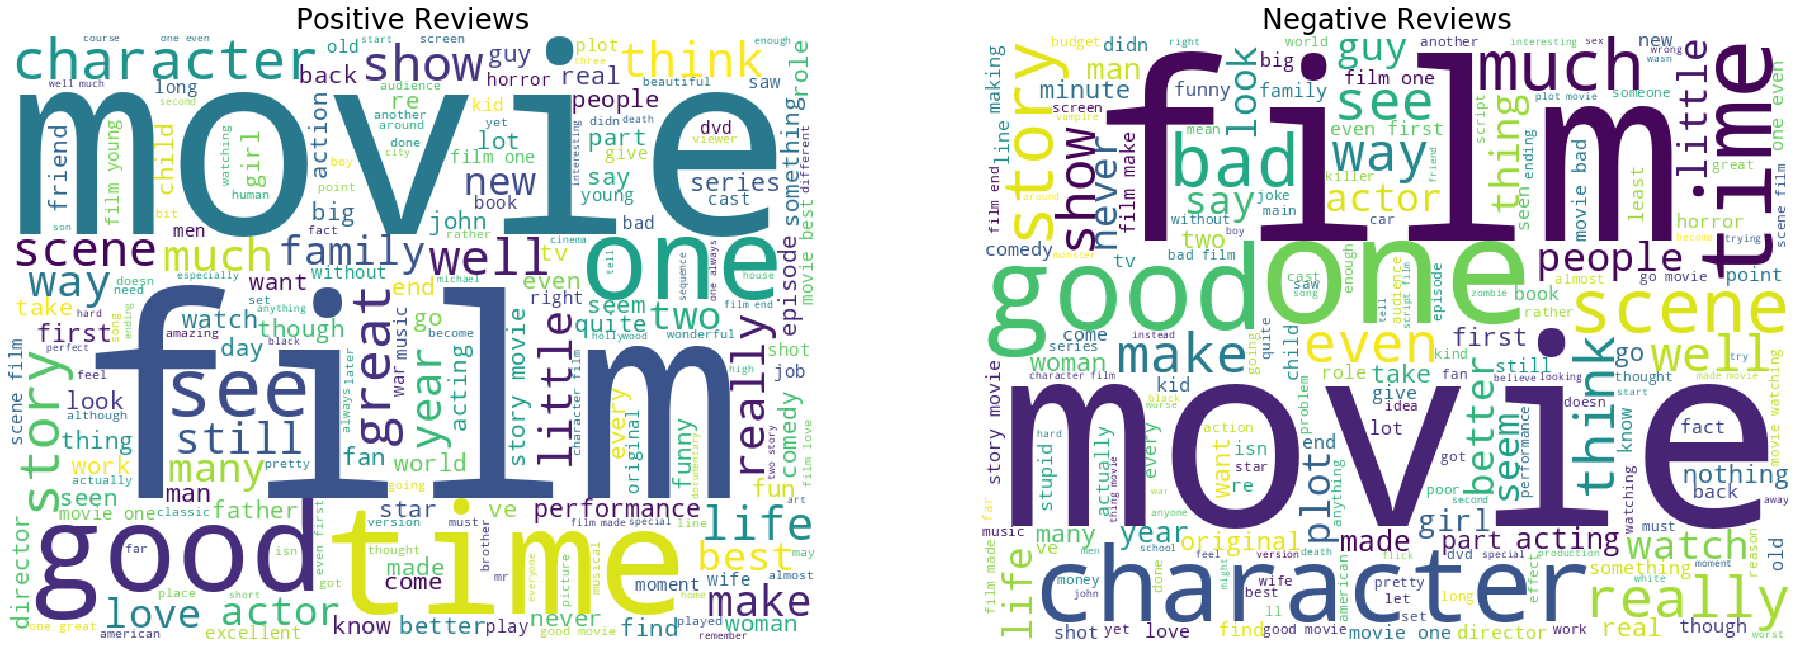

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[32,18])
wc1 = WordCloud(background_color='white',width=640,height=480).generate(' '.join(pos))
wc2 = WordCloud(background_color='white', width=640,height=480).generate(' '.join(neg))

ax1.imshow(wc1)
ax1.axis('off')
ax1.set_title('Positive Reviews', fontsize=28)

ax2.imshow(wc2)
ax2.axis('off')
ax2.set_title('Negative Reviews', fontsize=28)
plt.show()

# Determine Accuracy over dev set

In [17]:
def get_conditional_prob(word, corpus, sentiment):
    total_prob = corpus[corpus['_class']==sentiment].shape[0]
    conditional_prob = corpus[(corpus['_class']==sentiment) \
                  & (corpus['_data'].map(set([word]).issubset))].shape[0]
    probability = conditional_prob/total_prob
    return probability

In [18]:
def calculate_sentiment(document, corpus, sentiment):

    p = 1
    for word in document:
        p = p*get_conditional_prob(word, corpus, sentiment)
    return p

In [ ]:
dev_df['_pos'] = dev_df['_data'].apply(lambda data: calculate_sentiment(data, train_df, 'pos'))

In [ ]:
dev_df['_neg'] = dev_df['_data'].apply(lambda data: calculate_sentiment(data, train_df, 'neg'))

In [ ]:
# newdf = dev_df[:10].copy()
# newdf['_pos'] = tdf1
# newdf['_neg'] = tdf2
# newdf['_pred'] = newdf.apply(lambda x: max(x['_pos'], x['_neg']), axis=1)

In [ ]:
dev_df.head(10)